In [2]:
from cvx.stat_arb.ccp import *
from utils import *
import seaborn as sns

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

In [24]:
prices_full = pd.read_csv("../data/stock_prices.csv", index_col=0, parse_dates=True)
market_cap = pd.read_csv("../data/market_cap.csv", index_col=0, parse_dates=True)
spreads = pd.read_csv("../data/spreads_stocks.csv", index_col=0, parse_dates=True)

PERMCO_to_COMNAM = pd.read_csv("../data/PERMCO_to_COMNAM.csv", index_col=0)

In [4]:
results, portfolios = run_backtest(
    prices_full,
    market_cap,
    spreads,
    P_max=100,
    moving_mean=True,
    T_max=125,
)

8% 16% 24% 32% 40% 48% 56% 64% 72% 80% 88% 96% 
Finished after 127 iterations


# Stat arb statistics

Total number of (potential) SAs found: 1270
Average number of assets per SA: 5.3
Median number of assets per SA: 5.0
Total number of validated SAs: 712
max: 10
min: 1


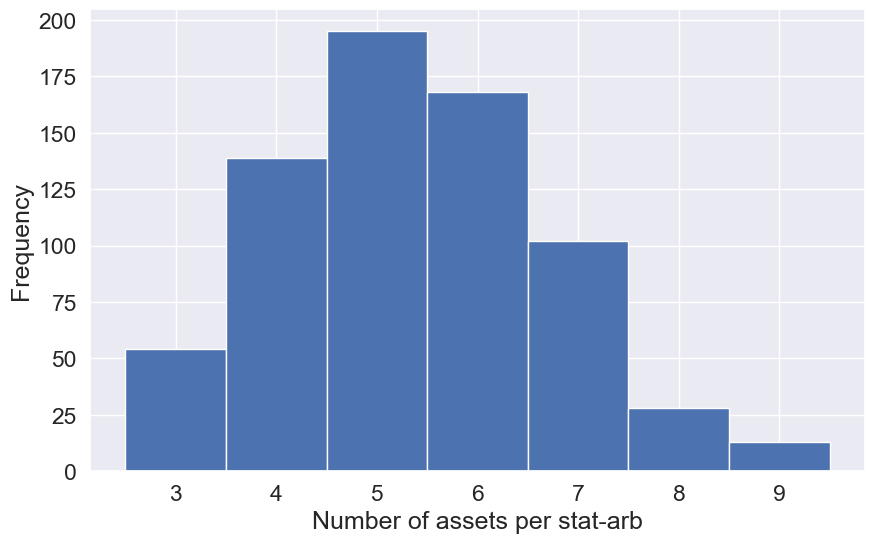

In [7]:
### How many assets per SA on average
lens = []
n_stat_arbs = 0

for res in results:
    stat_arb = res.stat_arb
    lens.append(stat_arb.stocks.shape[0])
    n_stat_arbs += 1

iterations=127
K=10
print(f"Total number of (potential) SAs found: {iterations*K}")
print(f"Average number of assets per SA: {np.mean(lens):.1f}")
print(f"Median number of assets per SA: {np.median(lens):.1f}")
print(f"Total number of validated SAs: {n_stat_arbs}")
print(f"max: {np.max(lens)}")
print(f"min: {np.min(lens)}")
plt.hist(lens, bins=np.arange(2.5, 10.5, 1));
plt.xlabel("Number of assets per stat-arb")
plt.ylabel("Frequency");


### Profits after transaction costs

In [8]:
all_traded_assets = []

for portfolio in portfolios:
    all_traded_assets += portfolio.stocks.columns.tolist()
all_traded_assets = list(set(all_traded_assets))

trading_cost_model=SpreadCostModel(spreads[all_traded_assets])


portfolios_after_cost = []

levs = []
for i, portfolio in enumerate(portfolios):
    res = results[i]
    portfolios_after_cost.append(
        simulate(res, portfolio, trading_cost_model, 0.5)
    )



Portfolio went bust at 2013-01-18 00:00:00
bust_sort: 1

Portfolio went bust at 2020-03-16 00:00:00
bust_sort: 1

Portfolio went bust at 2021-10-12 00:00:00
bust_sort: 1


In [127]:
stat_arb_metrics = metrics(portfolios_after_cost, results)

100%|██████████| 712/712 [00:39<00:00, 17.81it/s]


In [ ]:
avg_lens = np.mean(lens)
median_len = np.median(lens)
n_unique_stat_arbs = n_stat_arbs

means = stat_arb_metrics.means
stdevs = stat_arb_metrics.stdevs
sharpes = stat_arb_metrics.sharpes
profits = stat_arb_metrics.profits
min_navs = stat_arb_metrics.min_navs
min_cum_prof = stat_arb_metrics.min_cum_prof
drawdowns = stat_arb_metrics.drawdowns

print(f"Average number of assets per SA: {avg_lens:.1f}")
print(f"Median number of assets per SA: {median_len:.1f}")
print(f"Number of unique SAs: {n_unique_stat_arbs}")
print(f"Mean profit: {profits.mean():.2f}")
print(f"Median profit: {profits.median():.2f}")
print(f"Std profit: {profits.std():.2f}")
print(f"75th percentile: {profits.quantile(0.75):.2f}")
print(f"25th percentile: {profits.quantile(0.25):.2f}")
print(f"Fraction profitable: {(profits > 0).mean():.2f}")
print(f"Average minimum cumulative profit: {min_cum_prof.mean():.2f}")

print("\nMean return")
print(f"Mean return: {means.mean():.2f}")
print(f"Median return: {means.median():.2f}")
# print(f"Std return: {means.std():.2f}")
print(f"75th percentile return: {means.quantile(0.75):.2f}")
print(f"25th percentile return: {means.quantile(0.25):.2f}")
print(f"Fraction positive: {(means > 0).mean():.2f}")


print("\nRisk")
print(f"Mean risk: {stdevs.mean():.2f}")
print(f"Median risk: {stdevs.median():.2f}")
# print(f"Std risk: {stdevs.std():.2f}")
print(f"75th percentile risk: {stdevs.quantile(0.75):.2f}")
print(f"25th percentile risk: {stdevs.quantile(0.25):.2f}")

print("\nSharpe")
print(f"Average Sharpe: {sharpes.mean():.2f}")
print(f"Median Sharpe: {sharpes.median():.2f}")
# print(f"Std Sharpe: {sharpes.std():.2f}")
print(f"75th percentile Sharpe: {sharpes.quantile(0.75):.2f}")
print(f"25th percentile Sharpe: {sharpes.quantile(0.25):.2f}")
print(f"Fraction positive: {(sharpes > 0).mean():.2f}")

print("\nDrawdown")
print(f"Mean drawdown: {drawdowns.mean():.2f}")
print(f"Median drawdown: {drawdowns.median():.2f}")
# print(f"Std drawdown: {drawdowns.std():.2f}")
print(f"75th percentile drawdown: {drawdowns.quantile(0.75):.2f}")
print(f"25th percentile drawdown: {drawdowns.quantile(0.25):.2f}")


### Number of active stat arbs

In [11]:
times = prices_full.index
n_active = pd.Series(index=times, data=0)

for res in results:
    entry_date = res.metrics.entry_date
    exit_date = res.metrics.exit_date

    n_active.loc[entry_date:exit_date].iloc[:-1] += 1

n_active = n_active[n_active > 0]

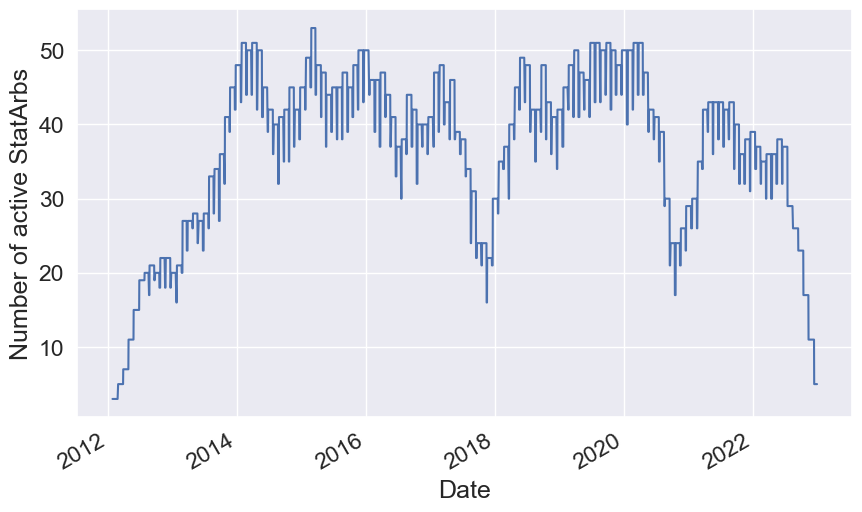

In [12]:
n_active.plot();
plt.ylabel("Number of active StatArbs");
plt.xlabel("Date");

In [13]:
print(f"Average number of active stat arbs: {n_active.mean():.2f}")
print(f"Median number of active stat arbs: {n_active.median():.2f}")
print(f"Maximum number of active stat arbs: {n_active.max():.2f}")
print(f"Minimum number of active stat arbs: {n_active.min():.2f}")

Average number of active stat arbs: 37.13
Median number of active stat arbs: 40.00
Maximum number of active stat arbs: 53.00
Minimum number of active stat arbs: 3.00


### Example stat arbs

In [79]:
quantile_low = 0.17
quantile_high = 0.685
quantiles = means.quantile([quantile_low, quantile_high])
quantiles

0.17   -0.014288
0.69    0.203918
dtype: float64

stat-arb:  -3.0×47896+7.0×21936+2.9×92655-4.9×19502-2.7×61399+6.8×11762+3.0×75034
profit:  -0.3656209208797244
exit trigger:  2014-09-23 00:00:00


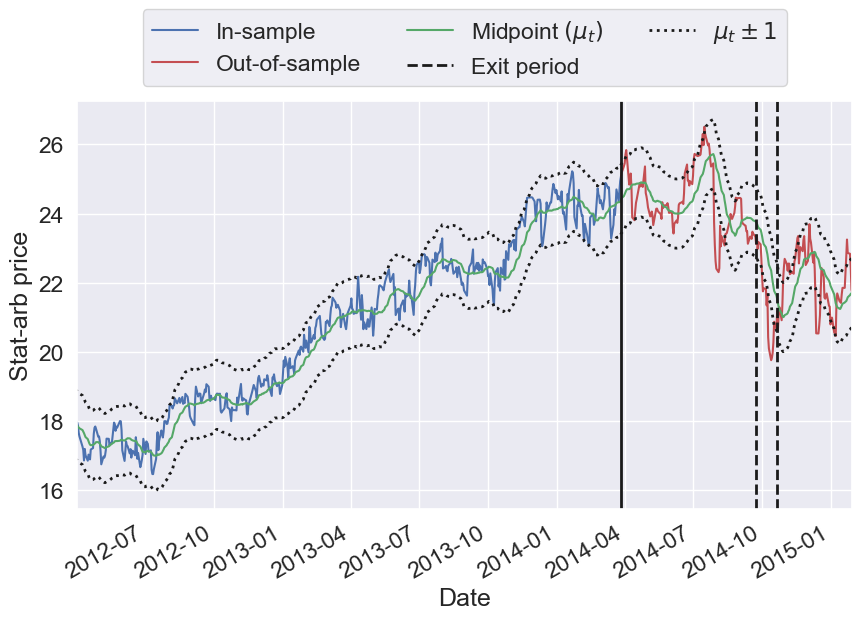

<Figure size 500x500 with 0 Axes>

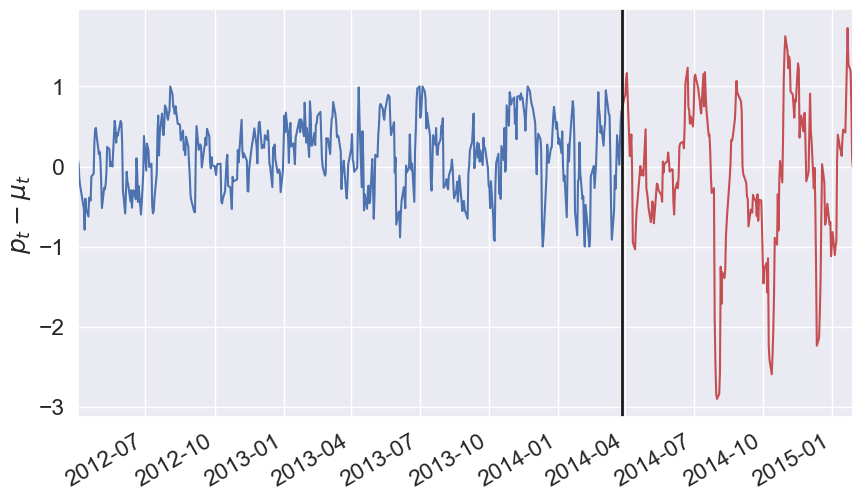

2111 5.6172987273275945


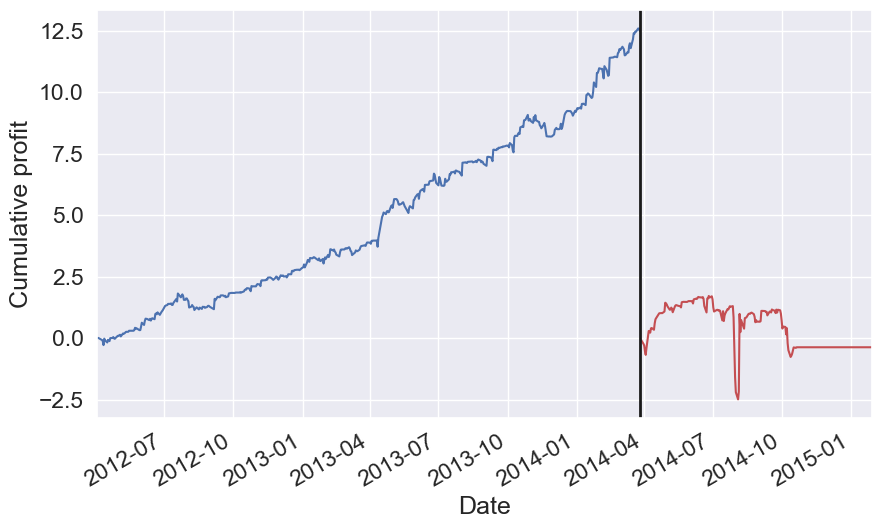

In [75]:
res_low = results[means[(means-quantiles[quantile_low]).abs().argsort()[:1]].index[0]]
plot_stat_arb(res_low, insample_bound=1, outsample_bound=np.inf);

stat-arb:  3.5×17005+0.6×76841-11.9×15488+5.4×91130+2.8×63830
profit:  2.2820112316967216
exit trigger:  2016-05-19 00:00:00


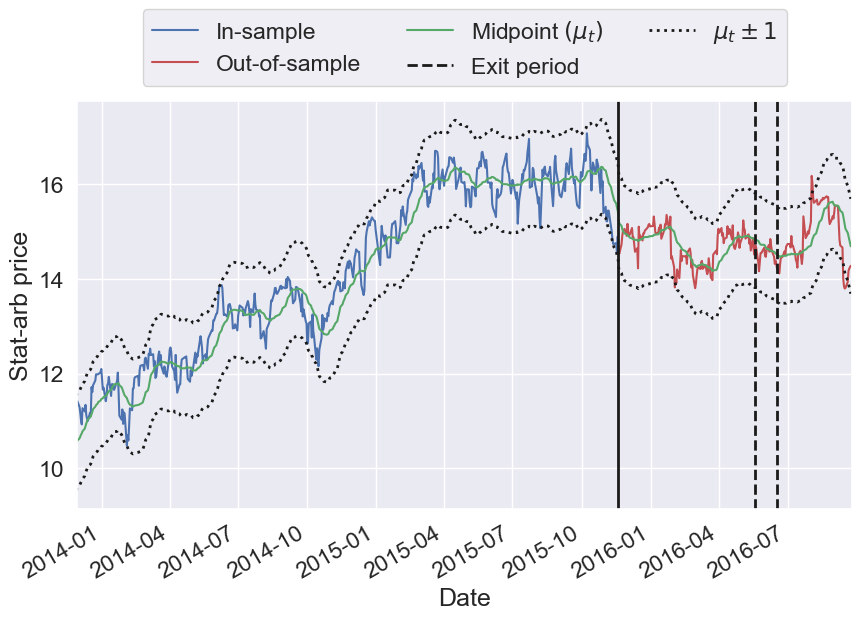

<Figure size 500x500 with 0 Axes>

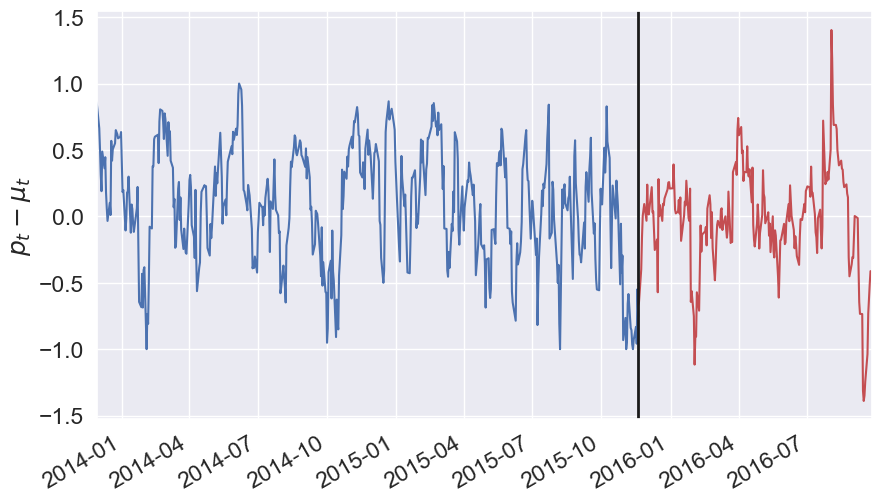

2111 0.6211161549142656


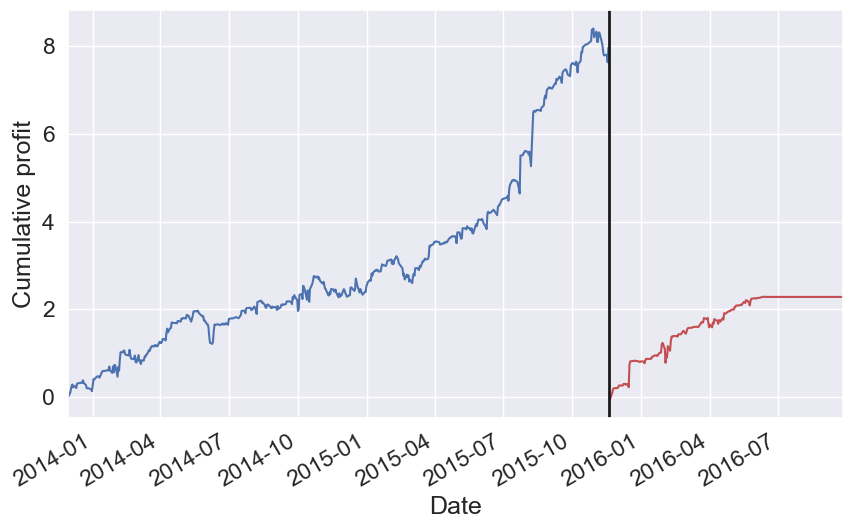

In [125]:
res_high = results[means[(means-quantiles[quantile_high]).abs().argsort()[:1]].index[0]]
plot_stat_arb(res_high, insample_bound=1, outsample_bound=np.inf);